### Imports

In [1]:
import time
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True)


def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi

    Parameters:
    smi (string) : smile string to be canonicalized

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)


def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie

    Parameters:
    selfie (string) : A selfie string - representing a molecule

    Example:
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']

    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters:
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)
    Returns:
        RDKit fingerprint object
    '''

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of
        class '_FingerprintCalculator'

    Parameters:
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)
    Returns:
        RDKit fingerprint object

    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on slefie is performed)

    Mutations are done until a valid molecule is obtained
    Rules of mutation: With a 33.3% propbabily, either:
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character

    Parameters:
    selfie            (string)  : SELFIE string to be mutated
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"

    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)

    while not valid:
        fail_counter += 1

        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]

        # Insert a character in a Random Location
        if random_choice == 1:
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]

            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character
        elif random_choice == 2:
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]

        # Delete a random character
        elif random_choice == 3:
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]

        else:
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)

        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()

    return (selfie_mutated, smiles_canon)

def get_mutated_SELFIES(selfies_ls, num_mutations):
    ''' Mutate all the SELFIES in 'selfies_ls' 'num_mutations' number of times.

    Parameters:
    selfies_ls   (list)  : A list of SELFIES
    num_mutations (int)  : number of mutations to perform on each SELFIES within 'selfies_ls'

    Returns:
    selfies_ls   (list)  : A list of mutated SELFIES

    '''
    for _ in range(num_mutations):
        selfie_ls_mut_ls = []
        for str_ in selfies_ls:

            str_chars = get_selfie_chars(str_)
            max_molecules_len = len(str_chars) + num_mutations

            selfie_mutated, _ = mutate_selfie(str_, max_molecules_len)
            selfie_ls_mut_ls.append(selfie_mutated)

        selfies_ls = selfie_ls_mut_ls.copy()
    return selfies_ls


def get_fp_scores(smiles_back, target_smi, fp_type):
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list
       of SMILES and a known target structure (target_smi).

    Parameters:
    smiles_back   (list) : A list of valid SMILES strings
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)

    Returns:
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back:
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores

### Visualize space

In [2]:
smi     = "COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1"
fp_type = 'ECFP4'


total_time = time.time()
num_random_samples = 3000 # For a more exhaustive search!
# num_random_samples = 1000
num_mutation_ls    = [1, 2, 3, 4, 5]

mol = Chem.MolFromSmiles(smi)
if mol == None:
    raise Exception('Invalid starting structure encountered')

start_time = time.time()
randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]

# Convert all the molecules to SELFIES
selfies_ls = [encoder(x) for x in randomized_smile_orderings]
print('Randomized molecules (in SELFIES) time: ', time.time()-start_time)


all_smiles_collect = []
all_smiles_collect_broken = []

start_time = time.time()
for num_mutations in num_mutation_ls:
    # Mutate the SELFIES:
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)

    # Convert back to SMILES:
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back
    all_smiles_collect_broken.append(smiles_back)


print('Mutation obtainment time (back to smiles): ', time.time()-start_time)


# Work on:  all_smiles_collect
start_time = time.time()
canon_smi_ls = []
for item in all_smiles_collect:
    mol, smi_canon, did_convert = sanitize_smiles(item)
    if mol == None or smi_canon == '' or did_convert == False:
        raise Exception('Invalid smile string found')
    canon_smi_ls.append(smi_canon)
canon_smi_ls        = list(set(canon_smi_ls))
print('Unique mutated structure obtainment time: ', time.time()-start_time)

start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', time.time()-start_time)
print('Total time: ', time.time()-total_time)

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

# Molecules with fingerprint similarity > 0.6
indices_thresh_6 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.6 and x < 0.8]
mols_6 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_6]

# Molecules with fingerprint similarity > 0.4
indices_thresh_4 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.4 and x < 0.6]
mols_4 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_4]

Randomized molecules (in SELFIES) time:  0.7303547859191895
Mutation obtainment time (back to smiles):  18.321797847747803
Unique mutated structure obtainment time:  1.6278307437896729
Fingerprint calculation time:  1.518735408782959
Total time:  22.199262142181396


In [3]:
# img=Draw.MolsToGridImage(mols_4[:8],molsPerRow=4,subImgSize=(200,200))
# img

### Model

In [4]:
import tensorflow as tf
import pandas as pd
from molgraph.models import GradientActivationMapping
from molgraph.chemistry import vis
import medchem as mc
from helpers import encode, encoder

model_file = "../saved_models/GAT"
model = tf.keras.models.load_model(model_file)

2023-12-28 22:56:17.663843: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 22:56:17.665224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 22:56:17.691794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 22:56:17.692432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 22:56:18.097601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
smiles = np.take(np.array(canon_smi_ls), indices_thresh_4)
df = pd.DataFrame({
    "smiles": smiles,
    "mol": [Chem.MolFromSmiles(i) for i in smiles],
    "inchi": [Chem.MolToInchi(Chem.MolFromSmiles(i)) for i in smiles]
})
# df["preds"] = model.predict(encoder(df.inchi.values))
df["rule_of_five"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_five)
df["rule_of_ghose"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_ghose)
df["rule_of_veber"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_veber)
df["rule_of_zinc"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_zinc)
df["filters_NIBR"] = mc.functional.nibr_filter(
    mols=df["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)
df = df.query("rule_of_five==True and rule_of_ghose==True and rule_of_veber==True and rule_of_zinc==True and filters_NIBR==True")
df["preds"] = model.predict(encoder(df.inchi.values))


38/38 [==============================] - 3s 6ms/step


In [8]:
df = df.sort_values(by="preds", ascending=True).query("preds >= 0.9")
df

,smiles,mol,inchi,rule_of_five,rule_of_ghose,rule_of_veber,rule_of_zinc,filters_NIBR,preds
685,COC1=C(CCN2CCOCC2)OC2(Nc3ccc(F)c(Cl)c3)C=NC=NC...,<rdkit.Chem.rdchem.Mol object at 0x7fd644bad2a0>,InChI=1S/C20H22ClFN4O3/c1-27-18-11-19-20(12-23...,True,True,True,True,True,0.900219
1772,C#CCc1cc(OCCCN2CCOCC2)c(OC)cc1N=C,<rdkit.Chem.rdchem.Mol object at 0x7fd644bcb220>,InChI=1S/C18H24N2O3/c1-4-6-15-13-18(17(21-3)14...,True,True,True,True,True,0.900502
1716,CC1=C2N=CN=C(Nc3ccc(F)c(Cl)c3)C2C(OCCCN2CCOCC2...,<rdkit.Chem.rdchem.Mol object at 0x7fd644bc99a0>,InChI=1S/C21H24ClFN4O3/c1-14-20-19(18(12-30-14...,True,True,True,True,True,0.901426
530,C=C1C=NCC(Nc2ccc(F)c(Cl)c2)=C1C(=COCCCN1CCOCC1)PC,<rdkit.Chem.rdchem.Mol object at 0x7fd644b0ce40>,InChI=1S/C22H28ClFN3O2P/c1-16-13-25-14-20(26-1...,True,True,True,True,True,0.902722
1865,FC1=C(Cl)NN(c2ncnc3ccc(OCCCN4CCOCC4)cc23)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fd644bcdb60>,InChI=1S/C19H23ClFN5O2/c20-18-16(21)4-6-26(24-...,True,True,True,True,True,0.903759
...,...,...,...,...,...,...,...,...,...
1872,CB=c1c(Nc2ccc(F)c(Cl)c2)ncnc1=CC(=COCCCN1CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x7fd644bcde70>,InChI=1S/C22H27BClFN4O3/c1-23-21-20(26-15-27-2...,True,True,True,True,True,0.998696
1698,COc1cc2ncnc(N=Bc3cc(Cl)bcc3F)c2cc1OCCCC1CCOC1,<rdkit.Chem.rdchem.Mol object at 0x7fd644bc91c0>,InChI=1S/C21H21B2ClFN3O3/c1-29-18-9-17-14(7-19...,True,True,True,True,True,0.998793
1606,COc1cc2ncnc(NCC3=CC(F)=C(Cl)CN3)c2cc1OBCCN1C[B...,<rdkit.Chem.rdchem.Mol object at 0x7fd644bc68f0>,InChI=1S/C20H24B2ClFN5O3/c1-30-18-8-17-14(7-19...,True,True,True,True,True,0.998940
1904,Cc1cc(Nc2ncnc3cc(BO)c(OCCCN4C=BCOC4)cc23)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7fd644bcec70>,InChI=1S/C21H23B2ClN4O3/c1-14-7-15(3-4-18(14)2...,True,True,True,True,True,0.999553


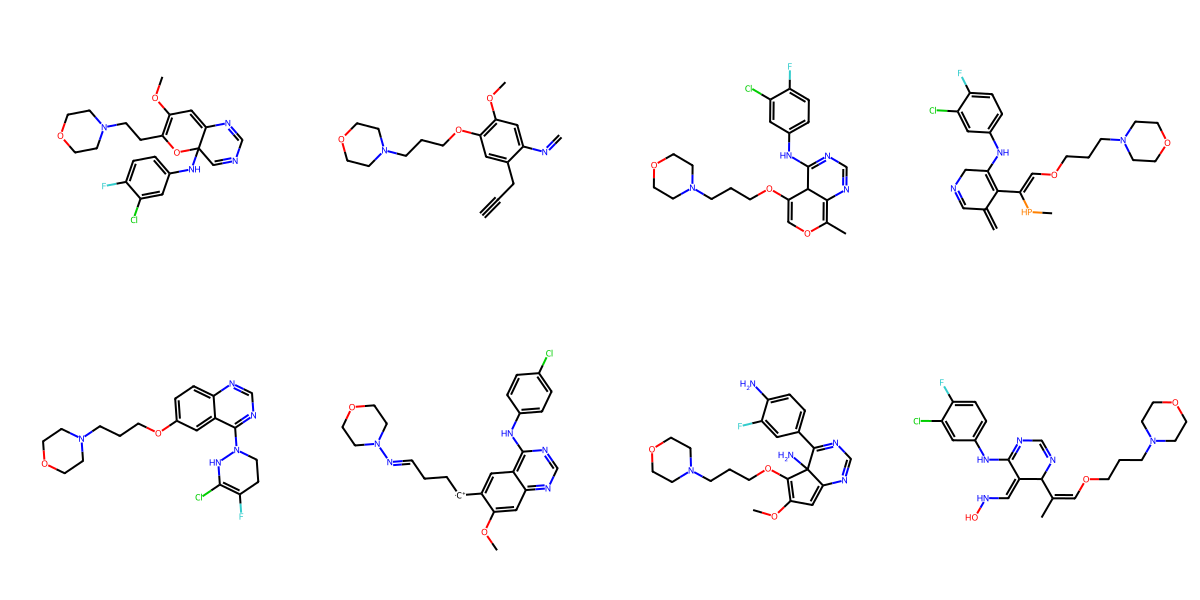

In [9]:
img=Draw.MolsToGridImage(df.mol[:8],molsPerRow=4,subImgSize=(300,300))
img